In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from PIL import Image
import os
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import time
import copy
from torch.optim.lr_scheduler import ReduceLROnPlateau
from io import BytesIO
import requests

In [46]:
class IdentityBlock(nn.Module):
    def __init__(self, in_channels, filters):
        super(IdentityBlock, self).__init__()
        F1, F2, F3 = filters

        self.conv1 = nn.Conv2d(in_channels, F1, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(F1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

        self.conv2 = nn.Conv2d(F1, F2, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(F2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

        self.conv3 = nn.Conv2d(F2, F3, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(F3)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)


    def forward(self, X):
        shortcut = X

        X = self.conv1(X)
        X = self.bn1(X)
        X = self.relu(X)
        X = self.dropout(X)

        X = self.conv2(X)
        X = self.bn2(X)
        X = self.relu(X)
        X = self.dropout(X)

        X = self.conv3(X)
        X = self.bn3(X)
        X = self.dropout(X)

        X += shortcut
        X = self.relu(X)
        return X

In [47]:
class ConvolutionalBlock(nn.Module):
    def __init__(self, in_channels, filters, s=2):
        super(ConvolutionalBlock, self).__init__()
        F1, F2, F3 = filters

        self.conv1 = nn.Conv2d(in_channels, F1, kernel_size=1, stride=s, padding=0)
        self.bn1 = nn.BatchNorm2d(F1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

        self.conv2 = nn.Conv2d(F1, F2, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(F2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

        self.conv3 = nn.Conv2d(F2, F3, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(F3)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)


        self.conv_shortcut = nn.Conv2d(in_channels, F3, kernel_size=1, stride=s, padding=0)
        self.bn_shortcut = nn.BatchNorm2d(F3)

    def forward(self, X):
        shortcut = X

        X = self.conv1(X)
        X = self.bn1(X)
        X = self.relu(X)
        X = self.dropout(X)

        X = self.conv2(X)
        X = self.bn2(X)
        X = self.relu(X)
        X = self.dropout(X)

        X = self.conv3(X)
        X = self.bn3(X)
        X = self.dropout(X)


        shortcut = self.conv_shortcut(shortcut)
        shortcut = self.bn_shortcut(shortcut)

        X += shortcut
        X = self.relu(X)

        return X

In [48]:
class ResNet50(nn.Module):
    def __init__(self, input_shape=(3, 224, 224), num_classes=6): # Sửa num_classes thành 6
        super(ResNet50, self).__init__()

        self.zero_pad = nn.ZeroPad2d(3)
        self.conv1 = nn.Conv2d(input_shape[0], 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.stage2 = nn.Sequential(
            ConvolutionalBlock(64, [64, 64, 256], s=1),
            IdentityBlock(256, [64, 64, 256]),
            IdentityBlock(256, [64, 64, 256])
        )

        self.stage3 = nn.Sequential(
            ConvolutionalBlock(256, [128, 128, 512], s=2),
            IdentityBlock(512, [128, 128, 512]),
            IdentityBlock(512, [128, 128, 512]),
            IdentityBlock(512, [128, 128, 512])
        )

        self.stage4 = nn.Sequential(
            ConvolutionalBlock(512, [256, 256, 1024], s=2),
            *[IdentityBlock(1024, [256, 256, 1024]) for _ in range(7)]
        )

        self.stage5 = nn.Sequential(
            ConvolutionalBlock(1024, [512, 512, 2048], s=2),
            IdentityBlock(2048, [512, 512, 2048]),
            IdentityBlock(2048, [512, 512, 2048])
        )

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # GlobalAvgPool2D
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, X):
        x = self.zero_pad(X)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.stage2(x)

        x = self.stage3(x)

        x = self.stage4(x)

        x = self.stage5(x)

        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [49]:
class ChessPiecesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.samples = []
        for target_class in self.classes:
            class_dir = os.path.join(self.root_dir, target_class)
            for root, _, fnames in sorted(os.walk(class_dir, followlinks=True)):
                for fname in sorted(fnames):
                    path = os.path.join(root, fname)
                    item = path, self.class_to_idx[target_class]
                    self.samples.append(item)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        sample = Image.open(path).convert('RGB')
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target


In [ ]:
# Data augmentation và transforms cải tiến
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=15), # Thêm RandomAffine
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), # Thêm ColorJitter
    transforms.RandomGrayscale(p=0.1), # Thêm RandomGrayscale
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = ChessPiecesDataset(root_dir='/kaggle/input/chess-data/ChessPieces_Dataset/train', transform=train_transforms)
val_dataset = ChessPiecesDataset(root_dir='/kaggle/input/chess-data/ChessPieces_Dataset/val', transform=val_test_transforms)
test_dataset = ChessPiecesDataset(root_dir='/kaggle/input/chess-data/ChessPieces_Dataset/test', transform=val_test_transforms)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [51]:
if torch.cuda.is_available():
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU detected. Running on CPU.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50(input_shape=(3, 224, 224), num_classes=6).to(device) # Giữ nguyên ResNet50 tùy chỉnh
model = model.to(device)
print(device)

GPU is available: Tesla T4
cuda


In [52]:
print(model)

ResNet50(
  (zero_pad): ZeroPad2d((3, 3, 3, 3))
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): ConvolutionalBlock(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.2, inplace=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_shortcut): Conv2d(64, 256, kernel_size=(1, 1), stride=(1

In [53]:
# Định nghĩa hàm mất mát và optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

In [54]:
# Huấn luyện
num_epochs = 100 # Tăng epochs lên 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_acc = 0.0
patience = 10 # Early stopping patience = 10 epochs
epochs_no_improve = 0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_dataset)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_loss = running_loss / len(val_dataset)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        epochs_no_improve = 0
        best_model_wts = copy.deepcopy(model.state_dict())
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs!")
            break

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

Epoch 1/100, Train Loss: 1.8331, Train Acc: 17.27%, Val Loss: 2.0901, Val Acc: 16.94%
Epoch 2/100, Train Loss: 1.8212, Train Acc: 17.13%, Val Loss: 2.4957, Val Acc: 16.94%
Epoch 3/100, Train Loss: 1.8129, Train Acc: 17.72%, Val Loss: 2.1496, Val Acc: 18.47%
Epoch 4/100, Train Loss: 1.8079, Train Acc: 18.46%, Val Loss: 2.4121, Val Acc: 19.72%
Epoch 5/100, Train Loss: 1.8057, Train Acc: 19.32%, Val Loss: 2.2310, Val Acc: 18.61%
Epoch 6/100, Train Loss: 1.7987, Train Acc: 20.38%, Val Loss: 2.4514, Val Acc: 19.03%
Epoch 7/100, Train Loss: 1.7933, Train Acc: 20.65%, Val Loss: 2.2485, Val Acc: 17.22%
Epoch 8/100, Train Loss: 1.7872, Train Acc: 21.21%, Val Loss: 3.9538, Val Acc: 15.69%
Epoch 9/100, Train Loss: 1.7598, Train Acc: 24.24%, Val Loss: 4.2962, Val Acc: 20.42%
Epoch 10/100, Train Loss: 1.7154, Train Acc: 27.18%, Val Loss: 3.3710, Val Acc: 23.06%
Epoch 11/100, Train Loss: 1.6648, Train Acc: 30.05%, Val Loss: 2.5591, Val Acc: 22.22%
Epoch 12/100, Train Loss: 1.6038, Train Acc: 34.07%,

In [55]:
model.load_state_dict(best_model_wts) # Load best weights

<All keys matched successfully>

In [56]:
model.eval()
correct = 0
total = 0
all_predictions = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f'Accuracy on the test set: {100 * correct / total:.2f}%')

Accuracy on the test set: 90.56%


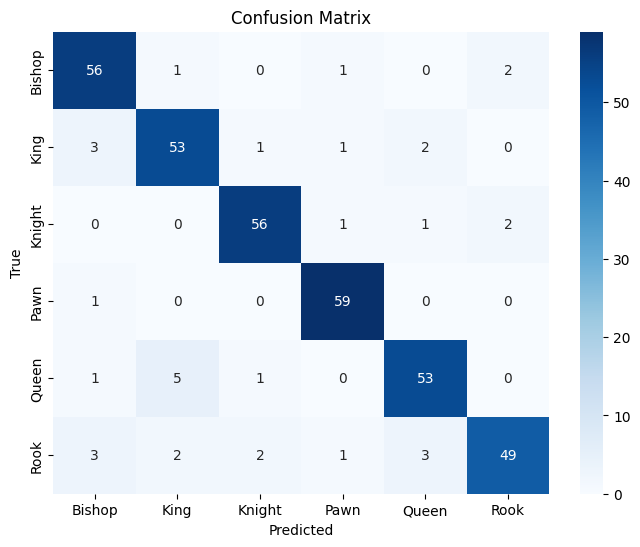

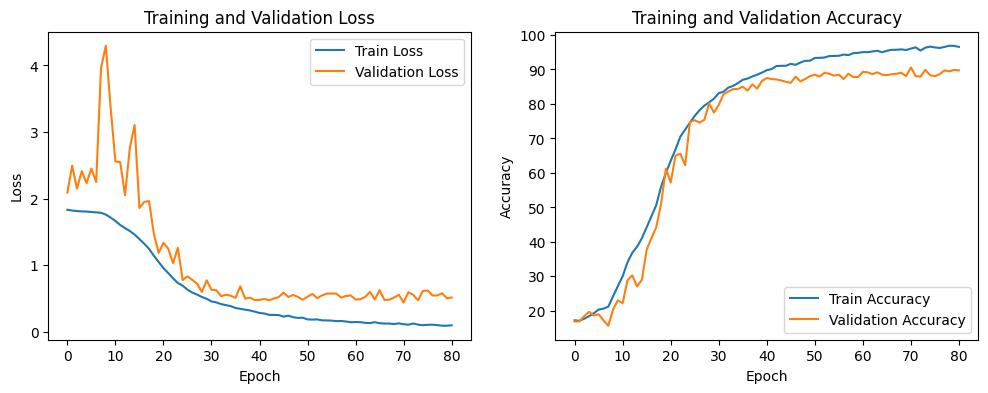

In [57]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
class_names = test_dataset.classes
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Vẽ loss và accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [58]:
torch.save(model.state_dict(), "/kaggle/working/chess_classifier_resnet_lr01_weight.pth")
print("Lưu mô hình ResNet50 tùy chỉnh thành công!")

Lưu mô hình ResNet50 tùy chỉnh thành công!


In [59]:
# Load mô hình
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('/kaggle/working/chess_classifier_resnet_lr01_weight.pth', map_location=device, weights_only=True))
model = model.to(device)
model.eval()

ResNet50(
  (zero_pad): ZeroPad2d((3, 3, 3, 3))
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): ConvolutionalBlock(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.2, inplace=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_shortcut): Conv2d(64, 256, kernel_size=(1, 1), stride=(1

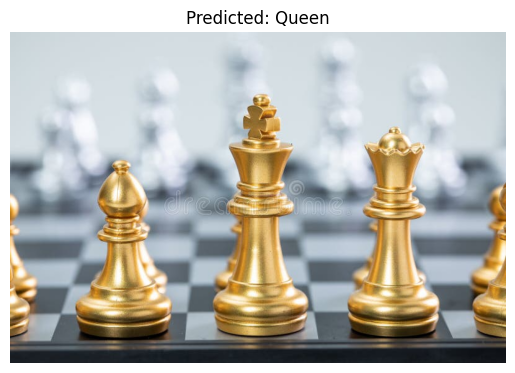

In [60]:
def predict_chess_piece(image_path, model):
    try:
        if image_path.startswith('http'):
            response = requests.get(image_path, stream=True)
            response.raise_for_status()
            img = Image.open(BytesIO(response.content)).convert('RGB')
        else:
            img = Image.open(image_path).convert('RGB')

        transform = val_test_transforms
        img_tensor = transform(img)
        img_tensor = img_tensor.unsqueeze(0)
        img_tensor = img_tensor.to(device)

        with torch.no_grad():
            output = model(img_tensor)
            _, predicted = torch.max(output.data, 1)
            class_names = ['Bishop', 'King', 'Knight', 'Pawn', 'Queen', 'Rook']
            predicted_class_name = class_names[predicted.item()]

        plt.imshow(img)
        plt.title(f'Predicted: {predicted_class_name}')
        plt.axis('off')
        plt.show()

        return predicted_class_name
    except requests.exceptions.RequestException as e:
        print(f"Lỗi khi tải ảnh từ URL: {e}")
        return None
    except FileNotFoundError:
        print(f"Không tìm thấy file ảnh tại đường dẫn: {image_path}")
        return None
    except Exception as e:
        print(f"Lỗi: {e}")
        return None


image_url = "https://thumbs.dreamstime.com/b/gold-silver-chess-white-background-business-leader-concept-market-target-strategy-intelligence-challenge-143408627.jpg"
predicted_piece = predict_chess_piece(image_url, model)